In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.transforms import RandomHorizontalFlip, RandomRotation
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support, jaccard_score
from tqdm import tqdm
from sklearn.metrics import f1_score

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def target_transform(mask):
    mask = mask.resize((224, 224), Image.NEAREST)
    mask = np.array(mask, dtype=np.int64)
    mask[mask >= 21] = 255
    mask = torch.tensor(mask, dtype=torch.long)
    return torch.tensor(mask)

In [ ]:
def load_pascal_voc(root, year="2012", image_set="train", transform=transform, target_transform=None):
    voc_dataset = VOCSegmentation(root=root, year=year, image_set=image_set, download=True)

    data = []
    for image, target in voc_dataset:
      image = transform(image)
      target = target_transform(target)
      data.append((image, target))
    return data

In [ ]:
train_dataset = load_pascal_voc(root="./data", image_set="trainval", transform=transform, target_transform=target_transform)
val_dataset = load_pascal_voc(root="./data", image_set="val", transform=transform, target_transform=target_transform)
test_dataset = load_pascal_voc(root="./data", image_set="train", transform=transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

C:\Users\chbha\AppData\Local\Temp\ipykernel_28512\1372225312.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask)


In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

2913 1449 1464


In [ ]:
class SegNet_Vgg(nn.Module):
    def __init__(self, encoder):
        super(SegNet_Vgg, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 21, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        latent_representation = x.clone()
        x = self.decoder(x)
        return x, latent_representation

In [ ]:
class SegNet_Eff(nn.Module):
    def __init__(self, encoder):
        super(SegNet_Eff, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 21, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        latent_representation = x.clone()
        x = self.decoder(x)
        return x, latent_representation

In [ ]:
vgg_encoder = models.vgg16(pretrained=True).features
for layer in vgg_encoder:
    layer.requires_grad = False

In [ ]:
efficientnet_encoder = models.efficientnet_b0(pretrained=True).features
for layer in efficientnet_encoder:
    layer.requires_grad = False

c:\Users\chbha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vgg_segnet = SegNet_Vgg(vgg_encoder).to(device)
efficientnet_segnet = SegNet_Eff(efficientnet_encoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer_vgg = optim.Adam(vgg_segnet.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_eff = optim.Adam(efficientnet_segnet.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def calculate_dice_score(y_true, y_pred, num_classes=21):
    dice_scores = {}
    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()

    for cls in range(num_classes):
        y_true_cls = (y_true_flat == cls).astype(int)
        y_pred_cls = (y_pred_flat == cls).astype(int)

        dice_score = f1_score(y_true_cls, y_pred_cls, zero_division=1)
        dice_scores[f"Class {cls}"] = dice_score

    dice_scores["Mean Dice Score"] = np.mean(list(dice_scores.values()))
    return dice_scores

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):

    model = model.to(device)

    best_model_weights = None
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs, _= model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validate]"):
                images, masks = images.to(device), masks.to(device)
                outputs, _ = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)

    return evaluate_model(model, test_loader, criterion, device)

def evaluate_model(model, test_loader, criterion, device):

    model.eval()
    model = model.to(device)

    total_loss = 0
    pixel_acc_list, mean_iou_list, dice_list = [], [], []
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)
            outputs, _= model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = masks.cpu().numpy()

            pixel_acc_list.append(np.mean(preds == targets))

            for pred, target in zip(preds, targets):
                mean_iou_list.append(jaccard_score(target.flatten(), pred.flatten(), average="macro"))
                dice_score = calculate_dice_score(target, pred, num_classes=21)
                y_true_all.extend(target.flatten())
                y_pred_all.extend(pred.flatten())

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average="macro")

    return {
        "Pixel Accuracy": np.mean(pixel_acc_list),
        "Mean IoU": np.mean(mean_iou_list),
        "F1 Score": f1_score,
        "Dice Score": dice_score,
        "Loss": total_loss / len(test_loader),
    }


In [ ]:
print("Training VGG-based SegNet")
train_and_evaluate(vgg_segnet, train_loader, val_loader, test_loader, criterion, optimizer_vgg, num_epochs=35, device = device)

Training VGG-based SegNet


Epoch 1/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.10it/s]


Epoch 1/35, Train Loss: 2.1226, Val Loss: 1.5621


Epoch 2/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.32it/s]


Epoch 2/35, Train Loss: 1.3412, Val Loss: 1.1874


Epoch 3/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.09it/s]


Epoch 3/35, Train Loss: 1.1118, Val Loss: 1.0627


Epoch 4/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.35it/s]


Epoch 4/35, Train Loss: 1.0046, Val Loss: 1.0524


Epoch 5/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00,  9.64it/s]


Epoch 5/35, Train Loss: 0.9207, Val Loss: 0.9596


Epoch 6/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.00it/s]


Epoch 6/35, Train Loss: 0.8380, Val Loss: 0.9224


Epoch 7/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.27it/s]


Epoch 7/35, Train Loss: 0.7677, Val Loss: 0.9196


Epoch 8/35 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.95it/s]


Epoch 8/35, Train Loss: 0.7080, Val Loss: 0.8719


Epoch 9/35 [Validate]: 100%|██████████| 182/182 [00:17<00:00, 10.12it/s]


Epoch 9/35, Train Loss: 0.6573, Val Loss: 0.8705


Epoch 10/35 [Validate]: 100%|██████████| 182/182 [00:22<00:00,  8.13it/s]


Epoch 10/35, Train Loss: 0.6184, Val Loss: 0.8583


Epoch 11/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.06it/s]


Epoch 11/35, Train Loss: 0.5725, Val Loss: 0.8044


Epoch 12/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.43it/s]


Epoch 12/35, Train Loss: 0.5052, Val Loss: 0.8320


Epoch 13/35 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.86it/s]


Epoch 13/35, Train Loss: 0.4409, Val Loss: 0.7294


Epoch 14/35 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  9.08it/s]


Epoch 14/35, Train Loss: 0.4007, Val Loss: 0.7635


Epoch 15/35 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.71it/s]


Epoch 15/35, Train Loss: 0.3714, Val Loss: 0.7313


Epoch 16/35 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.80it/s]


Epoch 16/35, Train Loss: 0.3247, Val Loss: 0.6916


Epoch 17/35 [Validate]: 100%|██████████| 182/182 [00:21<00:00,  8.44it/s]


Epoch 17/35, Train Loss: 0.2871, Val Loss: 0.6879


Epoch 18/35 [Validate]: 100%|██████████| 182/182 [00:21<00:00,  8.65it/s]


Epoch 18/35, Train Loss: 0.2607, Val Loss: 0.7608


Epoch 19/35 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.75it/s]


Epoch 19/35, Train Loss: 0.2452, Val Loss: 0.7076


Epoch 20/35 [Validate]: 100%|██████████| 182/182 [00:23<00:00,  7.59it/s]


Epoch 20/35, Train Loss: 0.2227, Val Loss: 0.7003


Epoch 21/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00,  9.61it/s]


Epoch 21/35, Train Loss: 0.2025, Val Loss: 0.7119


Epoch 22/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00,  9.74it/s]


Epoch 22/35, Train Loss: 0.1835, Val Loss: 0.6890


Epoch 23/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00,  9.78it/s]


Epoch 23/35, Train Loss: 0.1734, Val Loss: 0.7194


Epoch 24/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.50it/s]


Epoch 24/35, Train Loss: 0.1607, Val Loss: 0.7263


Epoch 25/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.46it/s]


Epoch 25/35, Train Loss: 0.1608, Val Loss: 0.7004


Epoch 26/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00,  9.93it/s]


Epoch 26/35, Train Loss: 0.1417, Val Loss: 0.7030


Epoch 27/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.02it/s]


Epoch 27/35, Train Loss: 0.1236, Val Loss: 0.7129


Epoch 28/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00,  9.93it/s]


Epoch 28/35, Train Loss: 0.1144, Val Loss: 0.7604


Epoch 29/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.02it/s]


Epoch 29/35, Train Loss: 0.1166, Val Loss: 0.7198


Epoch 30/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.48it/s]


Epoch 30/35, Train Loss: 0.2330, Val Loss: 0.7447


Epoch 31/35 [Validate]: 100%|██████████| 182/182 [00:17<00:00, 10.27it/s]


Epoch 31/35, Train Loss: 0.1511, Val Loss: 0.6615


Epoch 32/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.06it/s]


Epoch 32/35, Train Loss: 0.1052, Val Loss: 0.6984


Epoch 33/35 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.02it/s]


Epoch 33/35, Train Loss: 0.0906, Val Loss: 0.7232


Epoch 34/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.57it/s]


Epoch 34/35, Train Loss: 0.0839, Val Loss: 0.7570


Epoch 35/35 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.49it/s]


Epoch 35/35, Train Loss: 0.0815, Val Loss: 0.7726


Testing: 100%|██████████| 183/183 [04:00<00:00,  1.31s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Pixel Accuracy': 0.8100067543667057,
 'Mean IoU': 0.2740055142989091,
 'F1 Score': 0.5876558549198992,
 'Dice Score': {'Class 0': 0.4691322433178205,
  'Class 1': 1.0,
  'Class 2': 1.0,
  'Class 3': 1.0,
  'Class 4': 1.0,
  'Class 5': 1.0,
  'Class 6': 1.0,
  'Class 7': 1.0,
  'Class 8': 1.0,
  'Class 9': 1.0,
  'Class 10': 1.0,
  'Class 11': 1.0,
  'Class 12': 1.0,
  'Class 13': 1.0,
  'Class 14': 1.0,
  'Class 15': 0.4805926165149466,
  'Class 16': 0.0,
  'Class 17': 1.0,
  'Class 18': 1.0,
  'Class 19': 1.0,
  'Class 20': 1.0,
  'Mean Dice Score': 0.902367850468227},
 'Loss': 0.8093595049583195}

In [ ]:
print("Training EfficientNet-based SegNet")
train_and_evaluate(efficientnet_segnet, train_loader, val_loader, test_loader, criterion, optimizer_eff, num_epochs=35, device = device)

Training EfficientNet-based SegNet


Epoch 1/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.86it/s]


Epoch 1/35, Train Loss: 2.1391, Val Loss: 1.4985


Epoch 2/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.77it/s]


Epoch 2/35, Train Loss: 1.3009, Val Loss: 1.0913


Epoch 3/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.94it/s]


Epoch 3/35, Train Loss: 1.0832, Val Loss: 0.9927


Epoch 4/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.97it/s]


Epoch 4/35, Train Loss: 0.9870, Val Loss: 0.9407


Epoch 5/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.78it/s]


Epoch 5/35, Train Loss: 0.9045, Val Loss: 0.8717


Epoch 6/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.84it/s]


Epoch 6/35, Train Loss: 0.8367, Val Loss: 0.8357


Epoch 7/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.80it/s]


Epoch 7/35, Train Loss: 0.7907, Val Loss: 0.8063


Epoch 8/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.03it/s]


Epoch 8/35, Train Loss: 0.7459, Val Loss: 0.7803


Epoch 9/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.95it/s]


Epoch 9/35, Train Loss: 0.7079, Val Loss: 0.7455


Epoch 10/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.72it/s]


Epoch 10/35, Train Loss: 0.6617, Val Loss: 0.7181


Epoch 11/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.97it/s]


Epoch 11/35, Train Loss: 0.6221, Val Loss: 0.6850


Epoch 12/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.06it/s]


Epoch 12/35, Train Loss: 0.5824, Val Loss: 0.6491


Epoch 13/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.15it/s]


Epoch 13/35, Train Loss: 0.5404, Val Loss: 0.6089


Epoch 14/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.95it/s]


Epoch 14/35, Train Loss: 0.4943, Val Loss: 0.5733


Epoch 15/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.02it/s]


Epoch 15/35, Train Loss: 0.4526, Val Loss: 0.5472


Epoch 16/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.92it/s]


Epoch 16/35, Train Loss: 0.4246, Val Loss: 0.5334


Epoch 17/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.74it/s]


Epoch 17/35, Train Loss: 0.3891, Val Loss: 0.5237


Epoch 18/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.85it/s]


Epoch 18/35, Train Loss: 0.3735, Val Loss: 0.5201


Epoch 19/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.40it/s]


Epoch 19/35, Train Loss: 0.3470, Val Loss: 0.5145


Epoch 20/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.63it/s]


Epoch 20/35, Train Loss: 0.3325, Val Loss: 0.4977


Epoch 21/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.44it/s]


Epoch 21/35, Train Loss: 0.3122, Val Loss: 0.5006


Epoch 22/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.90it/s]


Epoch 22/35, Train Loss: 0.2974, Val Loss: 0.5033


Epoch 23/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.01it/s]


Epoch 23/35, Train Loss: 0.2903, Val Loss: 0.4866


Epoch 24/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.81it/s]


Epoch 24/35, Train Loss: 0.2749, Val Loss: 0.4911


Epoch 25/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.77it/s]


Epoch 25/35, Train Loss: 0.2673, Val Loss: 0.4789


Epoch 26/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.96it/s]


Epoch 26/35, Train Loss: 0.2411, Val Loss: 0.4765


Epoch 27/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.96it/s]


Epoch 27/35, Train Loss: 0.2315, Val Loss: 0.4737


Epoch 28/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.99it/s]


Epoch 28/35, Train Loss: 0.2347, Val Loss: 0.4743


Epoch 29/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.10it/s]


Epoch 29/35, Train Loss: 0.2210, Val Loss: 0.4709


Epoch 30/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.71it/s]


Epoch 30/35, Train Loss: 0.2210, Val Loss: 0.4980


Epoch 31/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.34it/s]


Epoch 31/35, Train Loss: 0.2067, Val Loss: 0.4660


Epoch 32/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.93it/s]


Epoch 32/35, Train Loss: 0.1958, Val Loss: 0.4901


Epoch 33/35 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.01it/s]


Epoch 33/35, Train Loss: 0.2008, Val Loss: 0.4934


Epoch 34/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.97it/s]


Epoch 34/35, Train Loss: 0.1892, Val Loss: 0.4740


Epoch 35/35 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.59it/s]


Epoch 35/35, Train Loss: 0.1761, Val Loss: 0.4690


Testing: 100%|██████████| 183/183 [03:58<00:00,  1.30s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Pixel Accuracy': 0.8307937480832497,
 'Mean IoU': 0.3603690230933402,
 'F1 Score': 0.6659434078941026,
 'Dice Score': {'Class 0': 0.4953809127094326,
  'Class 1': 1.0,
  'Class 2': 1.0,
  'Class 3': 1.0,
  'Class 4': 1.0,
  'Class 5': 1.0,
  'Class 6': 1.0,
  'Class 7': 0.0,
  'Class 8': 1.0,
  'Class 9': 1.0,
  'Class 10': 1.0,
  'Class 11': 1.0,
  'Class 12': 1.0,
  'Class 13': 1.0,
  'Class 14': 1.0,
  'Class 15': 0.390553177999683,
  'Class 16': 1.0,
  'Class 17': 1.0,
  'Class 18': 1.0,
  'Class 19': 1.0,
  'Class 20': 1.0,
  'Mean Dice Score': 0.8993301947956721},
 'Loss': 0.4668815824829164}

In [ ]:
def visualize_segmentation(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs, _= model(images)
            outputs = torch.argmax(outputs, dim=1).cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Input Image")

            axes[1].imshow(masks[0].cpu().numpy(), cmap="jet")
            axes[1].set_title("Ground Truth Mask")

            axes[2].imshow(outputs[0], cmap="jet")
            axes[2].set_title("Predicted Mask")

            plt.show()
            break


Visualizing Results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


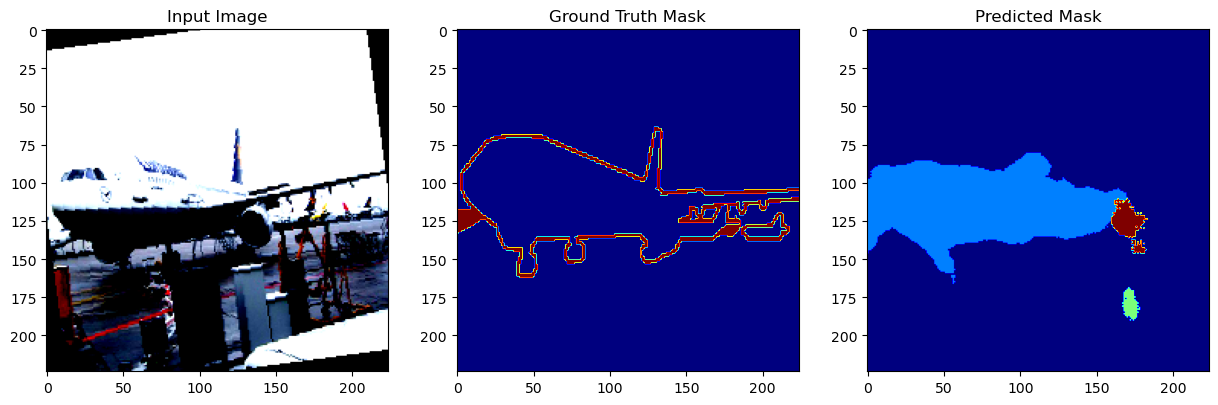

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


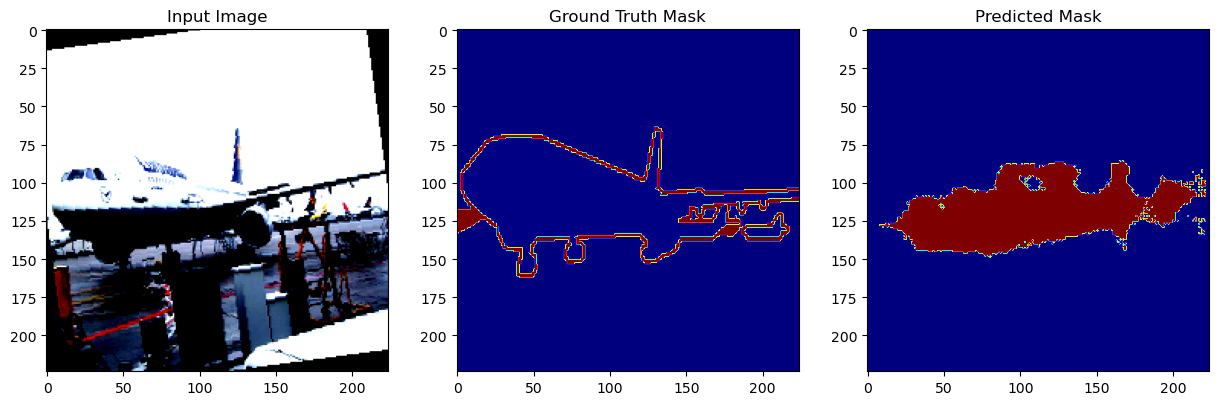

In [ ]:
print("Visualizing Results")
visualize_segmentation(vgg_segnet, val_loader)
visualize_segmentation(efficientnet_segnet, val_loader)

In [ ]:
def hyperparameter_tuning(train_loader, val_loader, test_loader, model_fn, criterion, learning_rates, batch_sizes, num_epochs=10, device = device):
    results = {}

    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training with LR: {lr}, Batch Size: {batch_size}")
            model = model_fn().to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)

            metrics = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device = device)
            results[(lr, batch_size)] = metrics

            print(f"Metrics: {metrics}")

    return results

In [ ]:
vgg_segnet_fn = lambda: SegNet_Vgg(vgg_encoder)
efficientnet_segnet_fn = lambda: SegNet_Eff(efficientnet_encoder)

In [ ]:
learning_rates = [1e-4, 1e-3]
batch_sizes = [16, 32]

vgg_results = hyperparameter_tuning(train_loader, val_loader, test_loader, vgg_segnet_fn, criterion, learning_rates, batch_sizes,num_epochs=10, device=device)
efficientnet_results = hyperparameter_tuning(train_loader, val_loader, test_loader, efficientnet_segnet_fn, criterion, learning_rates, batch_sizes, num_epochs=10, device=device)


Training with LR: 0.0001, Batch Size: 16


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.91it/s]


Epoch 1/10, Train Loss: 2.1500, Val Loss: 1.5998


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.93it/s]


Epoch 2/10, Train Loss: 1.3607, Val Loss: 1.1747


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.87it/s]


Epoch 3/10, Train Loss: 1.1244, Val Loss: 1.0753


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:19<00:00,  9.13it/s]


Epoch 4/10, Train Loss: 1.0197, Val Loss: 1.0453


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:20<00:00,  8.95it/s]


Epoch 5/10, Train Loss: 0.9457, Val Loss: 0.9854


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:17<00:00, 10.21it/s]


Epoch 6/10, Train Loss: 0.8654, Val Loss: 0.9671


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.06it/s]


Epoch 7/10, Train Loss: 0.7988, Val Loss: 0.9257


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:17<00:00, 10.15it/s]


Epoch 8/10, Train Loss: 0.7192, Val Loss: 0.8888


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:17<00:00, 10.15it/s]


Epoch 9/10, Train Loss: 0.6613, Val Loss: 0.8521


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.04it/s]


Epoch 10/10, Train Loss: 0.6167, Val Loss: 0.8349


Testing: 100%|██████████| 183/183 [03:54<00:00,  1.28s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.7557007530214955, 'Mean IoU': 0.19436709684253753, 'F1 Score': 0.21802269836761703, 'Dice Score': {'Class 0': 0.5051040318770924, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 0.0, 'Class 7': 0.0, 'Class 8': 0.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.4958462492250465, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.8095690610048637}, 'Loss': 0.8336032366817766}
Training with LR: 0.0001, Batch Size: 32


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:18<00:00, 10.01it/s]


Epoch 1/10, Train Loss: 1.9719, Val Loss: 1.3715


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:22<00:00,  8.12it/s]


Epoch 2/10, Train Loss: 1.0435, Val Loss: 1.0573


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:22<00:00,  7.92it/s]


Epoch 3/10, Train Loss: 0.8038, Val Loss: 0.9639


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:26<00:00,  6.76it/s]


Epoch 4/10, Train Loss: 0.6980, Val Loss: 0.9123


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:26<00:00,  7.00it/s]


Epoch 5/10, Train Loss: 0.6358, Val Loss: 0.9023


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:25<00:00,  7.08it/s]


Epoch 6/10, Train Loss: 0.6006, Val Loss: 0.8915


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:26<00:00,  6.99it/s]


Epoch 7/10, Train Loss: 0.5462, Val Loss: 0.8410


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.34it/s]


Epoch 8/10, Train Loss: 0.5116, Val Loss: 0.8514


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.38it/s]


Epoch 9/10, Train Loss: 0.4825, Val Loss: 0.8424


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.35it/s]


Epoch 10/10, Train Loss: 0.4712, Val Loss: 0.8800


Testing: 100%|██████████| 183/183 [03:57<00:00,  1.30s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.758770208102452, 'Mean IoU': 0.19243306130057264, 'F1 Score': 0.25343740614579907, 'Dice Score': {'Class 0': 0.4331274849843499, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.4735932096824898, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.9479390806984208}, 'Loss': 0.900035826560578}
Training with LR: 0.001, Batch Size: 16


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.35it/s]


Epoch 1/10, Train Loss: 1.3826, Val Loss: 1.2258


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.37it/s]


Epoch 2/10, Train Loss: 1.2211, Val Loss: 1.2401


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.42it/s]


Epoch 3/10, Train Loss: 1.2080, Val Loss: 1.1950


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.37it/s]


Epoch 4/10, Train Loss: 1.1891, Val Loss: 1.2316


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.40it/s]


Epoch 5/10, Train Loss: 1.1853, Val Loss: 1.1756


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.37it/s]


Epoch 6/10, Train Loss: 1.1770, Val Loss: 1.1612


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.40it/s]


Epoch 7/10, Train Loss: 1.1714, Val Loss: 1.1655


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.44it/s]


Epoch 8/10, Train Loss: 1.1634, Val Loss: 1.1469


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.39it/s]


Epoch 9/10, Train Loss: 1.1511, Val Loss: 1.1648


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.38it/s]


Epoch 10/10, Train Loss: 1.1408, Val Loss: 1.1325


Testing: 100%|██████████| 183/183 [03:57<00:00,  1.30s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.699561396343886, 'Mean IoU': 0.20826176683038694, 'F1 Score': 0.05431401735413492, 'Dice Score': {'Class 0': 0.5117735558587873, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.3383392656882344, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.9452434676927153}, 'Loss': 1.1295253067720132}
Training with LR: 0.001, Batch Size: 32


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:23<00:00,  7.64it/s]


Epoch 1/10, Train Loss: 1.3047, Val Loss: 1.1796


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.44it/s]


Epoch 2/10, Train Loss: 1.1457, Val Loss: 1.1801


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.37it/s]


Epoch 3/10, Train Loss: 1.1268, Val Loss: 1.1174


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.46it/s]


Epoch 4/10, Train Loss: 1.1021, Val Loss: 1.1452


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.32it/s]


Epoch 5/10, Train Loss: 1.0833, Val Loss: 1.0869


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.45it/s]


Epoch 6/10, Train Loss: 1.0654, Val Loss: 1.1039


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.36it/s]


Epoch 7/10, Train Loss: 1.0542, Val Loss: 1.0863


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.39it/s]


Epoch 8/10, Train Loss: 1.0339, Val Loss: 1.0743


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.36it/s]


Epoch 9/10, Train Loss: 1.0132, Val Loss: 1.0961


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:24<00:00,  7.39it/s]


Epoch 10/10, Train Loss: 1.0014, Val Loss: 1.0571


Testing: 100%|██████████| 183/183 [03:57<00:00,  1.30s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.7125968639569045, 'Mean IoU': 0.19887574651683765, 'F1 Score': 0.10806598862051651, 'Dice Score': {'Class 0': 0.5688211595726047, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 0.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.4277991107518189, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.904600965253544}, 'Loss': 1.0492609514564764}
Training with LR: 0.0001, Batch Size: 16


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.87it/s]


Epoch 1/10, Train Loss: 2.0711, Val Loss: 1.4687


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.58it/s]


Epoch 2/10, Train Loss: 1.2879, Val Loss: 1.1183


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.71it/s]


Epoch 3/10, Train Loss: 1.0791, Val Loss: 1.0166


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.80it/s]


Epoch 4/10, Train Loss: 0.9874, Val Loss: 0.9413


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.71it/s]


Epoch 5/10, Train Loss: 0.9104, Val Loss: 0.8741


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.77it/s]


Epoch 6/10, Train Loss: 0.8520, Val Loss: 0.8487


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.74it/s]


Epoch 7/10, Train Loss: 0.8095, Val Loss: 0.8345


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.69it/s]


Epoch 8/10, Train Loss: 0.7742, Val Loss: 0.8131


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.51it/s]


Epoch 9/10, Train Loss: 0.7308, Val Loss: 0.7852


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.74it/s]


Epoch 10/10, Train Loss: 0.6951, Val Loss: 0.7413


Testing: 100%|██████████| 183/183 [03:55<00:00,  1.29s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.7565923550196206, 'Mean IoU': 0.23902917822391825, 'F1 Score': 0.22339797744718656, 'Dice Score': {'Class 0': 0.41047944496220357, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.4204830143300932, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.9443315456805856}, 'Loss': 0.735386434474278}
Training with LR: 0.0001, Batch Size: 32


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.85it/s]


Epoch 1/10, Train Loss: 2.0991, Val Loss: 1.4182


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.74it/s]


Epoch 2/10, Train Loss: 1.1402, Val Loss: 1.0537


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.48it/s]


Epoch 3/10, Train Loss: 0.9183, Val Loss: 0.9690


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.70it/s]


Epoch 4/10, Train Loss: 0.8336, Val Loss: 0.9050


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.75it/s]


Epoch 5/10, Train Loss: 0.7762, Val Loss: 0.8659


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.56it/s]


Epoch 6/10, Train Loss: 0.7260, Val Loss: 0.8248


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.86it/s]


Epoch 7/10, Train Loss: 0.6819, Val Loss: 0.7908


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.85it/s]


Epoch 8/10, Train Loss: 0.6429, Val Loss: 0.7536


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.48it/s]


Epoch 9/10, Train Loss: 0.5905, Val Loss: 0.6961


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.03it/s]


Epoch 10/10, Train Loss: 0.5472, Val Loss: 0.6664


Testing: 100%|██████████| 183/183 [03:50<00:00,  1.26s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.7762037328058784, 'Mean IoU': 0.2448006571242339, 'F1 Score': 0.3231753134204403, 'Dice Score': {'Class 0': 0.3895848054645511, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.44006293828551446, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.9442689401785745}, 'Loss': 0.6570152272292173}
Training with LR: 0.001, Batch Size: 16


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.03it/s]


Epoch 1/10, Train Loss: 1.2444, Val Loss: 1.0506


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.06it/s]


Epoch 2/10, Train Loss: 1.0464, Val Loss: 0.9716


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.67it/s]


Epoch 3/10, Train Loss: 0.9844, Val Loss: 0.9552


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.97it/s]


Epoch 4/10, Train Loss: 0.9294, Val Loss: 0.9177


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.95it/s]


Epoch 5/10, Train Loss: 0.9099, Val Loss: 0.9067


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.75it/s]


Epoch 6/10, Train Loss: 0.8709, Val Loss: 0.9070


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.13it/s]


Epoch 7/10, Train Loss: 0.8477, Val Loss: 0.8916


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:13<00:00, 13.99it/s]


Epoch 8/10, Train Loss: 0.8253, Val Loss: 0.8438


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.08it/s]


Epoch 9/10, Train Loss: 0.7857, Val Loss: 0.8331


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.08it/s]


Epoch 10/10, Train Loss: 0.7585, Val Loss: 0.8142


Testing: 100%|██████████| 183/183 [03:47<00:00,  1.25s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.747505365811796, 'Mean IoU': 0.22703707688290176, 'F1 Score': 0.22368394628068203, 'Dice Score': {'Class 0': 0.42689407984179956, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.43256638594511826, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.9456885936089008}, 'Loss': 0.8298653429323207}
Training with LR: 0.001, Batch Size: 32


Epoch 1/10 [Validate]: 100%|██████████| 182/182 [00:16<00:00, 11.11it/s]


Epoch 1/10, Train Loss: 1.1056, Val Loss: 0.9883


Epoch 2/10 [Validate]: 100%|██████████| 182/182 [00:10<00:00, 16.60it/s]


Epoch 2/10, Train Loss: 0.8463, Val Loss: 0.8855


Epoch 3/10 [Validate]: 100%|██████████| 182/182 [00:10<00:00, 16.93it/s]


Epoch 3/10, Train Loss: 0.7905, Val Loss: 0.8499


Epoch 4/10 [Validate]: 100%|██████████| 182/182 [00:10<00:00, 16.56it/s]


Epoch 4/10, Train Loss: 0.7626, Val Loss: 0.8470


Epoch 5/10 [Validate]: 100%|██████████| 182/182 [00:10<00:00, 16.78it/s]


Epoch 5/10, Train Loss: 0.7372, Val Loss: 0.9216


Epoch 6/10 [Validate]: 100%|██████████| 182/182 [00:10<00:00, 17.12it/s]


Epoch 6/10, Train Loss: 0.7030, Val Loss: 0.8461


Epoch 7/10 [Validate]: 100%|██████████| 182/182 [00:11<00:00, 15.70it/s]


Epoch 7/10, Train Loss: 0.6810, Val Loss: 0.8066


Epoch 8/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.11it/s]


Epoch 8/10, Train Loss: 0.6397, Val Loss: 0.7519


Epoch 9/10 [Validate]: 100%|██████████| 182/182 [00:12<00:00, 14.12it/s]


Epoch 9/10, Train Loss: 0.6251, Val Loss: 0.7839


Epoch 10/10 [Validate]: 100%|██████████| 182/182 [00:11<00:00, 16.37it/s]


Epoch 10/10, Train Loss: 0.5951, Val Loss: 0.7554


Testing: 100%|██████████| 183/183 [03:47<00:00,  1.24s/it]
c:\Users\chbha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'Pixel Accuracy': 0.7673565279723571, 'Mean IoU': 0.23651630878281393, 'F1 Score': 0.3242306218827598, 'Dice Score': {'Class 0': 0.5031196016664973, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.493843797856049, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.9522363523582165}, 'Loss': 0.7503207705385698}


In [ ]:
print("\nVGG Results:")
for params, metrics in vgg_results.items():
    print(f"Params: {params}, Metrics: {metrics}")

print("\nEfficientNet Results:")
for params, metrics in efficientnet_results.items():
    print(f"Params: {params}, Metrics: {metrics}")


VGG Results:
Params: (0.0001, 16), Metrics: {'Pixel Accuracy': 0.7557007530214955, 'Mean IoU': 0.19436709684253753, 'F1 Score': 0.21802269836761703, 'Dice Score': {'Class 0': 0.5051040318770924, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 0.0, 'Class 7': 0.0, 'Class 8': 0.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.0, 'Class 14': 1.0, 'Class 15': 0.4958462492250465, 'Class 16': 1.0, 'Class 17': 1.0, 'Class 18': 1.0, 'Class 19': 1.0, 'Class 20': 1.0, 'Mean Dice Score': 0.8095690610048637}, 'Loss': 0.8336032366817766}
Params: (0.0001, 32), Metrics: {'Pixel Accuracy': 0.758770208102452, 'Mean IoU': 0.19243306130057264, 'F1 Score': 0.25343740614579907, 'Dice Score': {'Class 0': 0.4331274849843499, 'Class 1': 1.0, 'Class 2': 1.0, 'Class 3': 1.0, 'Class 4': 1.0, 'Class 5': 1.0, 'Class 6': 1.0, 'Class 7': 1.0, 'Class 8': 1.0, 'Class 9': 1.0, 'Class 10': 1.0, 'Class 11': 1.0, 'Class 12': 1.0, 'Class 13': 1.